In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_resources = 50
num_agents = num_participants = 100

filename = "subgrad_resal_N%d_%.2f_n%d_m%d"%(num_points, eps_sublevel, num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947258942


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.000000020813085

In [8]:
true_x.shape, true_lamb.shape

((5000, 1), (50, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all,  
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                        percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Dual subgradient

In [10]:
price_max = 3 * true_lamb.max()
price_min = np.maximum(0, (1./3) * true_lamb.min())
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

### Best learning schedule

In [11]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

best_schedule = [np.inf, "0.1/sqrt(k)"] 

for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    all_results = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=1, num_iters=20, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

    if all_results["viol_primal_paver_xk"][-1] < best_schedule[0]:
        best_schedule = [all_results["viol_primal_paver_xk"][-1], alpha_k]

alpha_k='0.1/sqrt(k)'


/Users/tepars/Documents/postdoc/mra_primal_rec/mra/subgrad.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=1.2359E-02,  f_subopt_mra=1.2359E-02,  viol_xk=9.6606E+01, viol_mra=9.6606E+01, lamb_rel_diff=9.3669E-01
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=5.5614E-02,  f_subopt_mra=5.5614E-02,  viol_xk=9.3374E+01, viol_mra=9.3374E+01, lamb_rel_diff=1.4142E+00
alpha_k='1/k'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=9.7246E+01, viol_mra=9.7246E+01, lamb_rel_diff=1.1151E+00
alpha_k='10/k'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=5.5614E-02,  f_subopt_mra=5.5614E-02,  viol_xk=9.3374E+01, viol_mra=9.33

In [12]:
best_alpha_k = best_schedule[1]
print(f"{best_alpha_k=}")
func_alpha_k = func_alphas[best_alpha_k]

best_alpha_k='0.1/sqrt(k)'


In [14]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.dual_proj_subgradient(fun_agents_noisy_y, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=6.8583E-03,  viol_xk=4.2108E+02, viol_mra=2.9336E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=7.7579E-02,  f_subopt_mra=1.7039E-02,  viol_xk=9.9386E+01, viol_mra=1.5780E+01, lamb_rel_diff=9.6215E-01
epoch=99, f_subopt_xk=5.5614E-02,  f_subopt_mra=4.0965E-02,  viol_xk=1.0003E+02, viol_mra=1.3716E+01, lamb_rel_diff=8.5322E-01
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.2226E-02,  viol_xk=4.2108E+02, viol_mra=4.0289E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=9.9386E+01, viol_mra=9.9386E+01, lamb_rel_diff=9.6215E-01
epoch=99, f_subopt_xk=5.5614E-02,  f_subopt_mra=5.5614E-02,  viol_xk=1.0003E+02, viol_mra=1.0003E+02, lamb_rel_diff=8.5322E-01


In [15]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_noisy_y = res["noisy_y"]
all_res = all_results_eps = res["eps"]

if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [10]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = 25#np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
idx_eps = np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk]/ b_norm,
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps]/ b_norm,
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y]/ b_norm,
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage]/ b_norm)

idx_xk=78, idx_eps=0, idx_noisy_y=25, idx_paverage=97
xk 0.05489554043091326 sub_eps 0.0068583390425028205 noisy_y 0.05561397836001263 proj inf paverage 0.05189415076941992
xk 0.33670195483728743 sub_eps 0.0 noisy_y 0.3913265974348793 paverage 0.23655934742589727


In [ ]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)


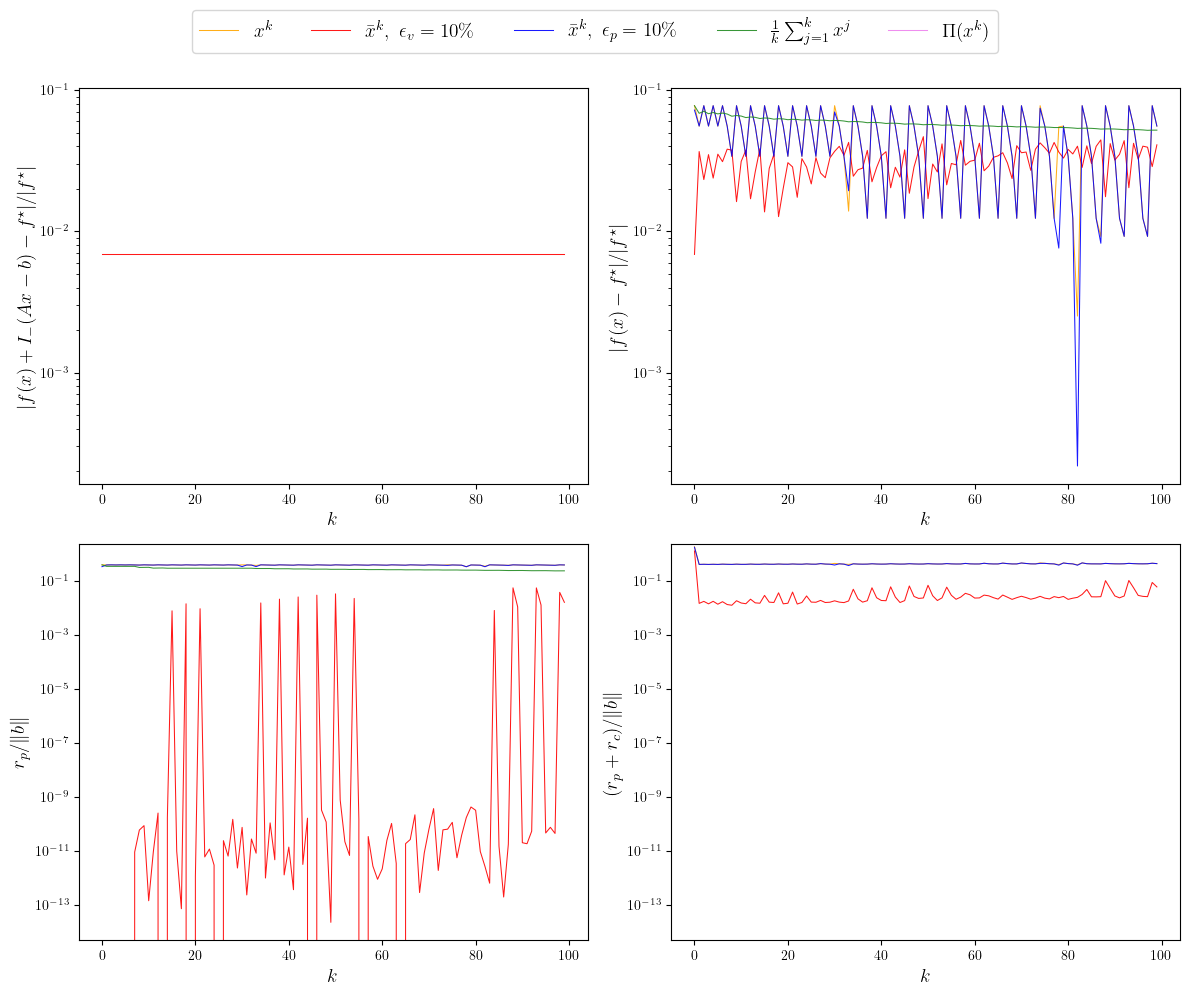

In [9]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)